In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

from glob import glob
from dask.delayed import delayed
import dask.dataframe as dd
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

import matplotlib.pylab as plt
plt.style.use('ggplot')

from utils import read_ngrams, save_ngrams, process, ARTICLES, AMENDMENTS, QUERIES

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [3]:
df_raw = read_ngrams("/mnt/volume_sfo2_03/downloads/google_ngrams/5/constitution-parsed-gz/part-*")
df_raw.columns = ['query', 'r1', 'r2', 'r3', 'year', 'total', 'distinct']
df_raw = df_raw.compute()

df = process(df_raw)
df = df[(df['year'] >= 1788) & ~ df['w'].isin(STOP_WORDS) & df['w'].str.isalnum()]

df.sample(10, random_state=42)

,w,query,year,total,distinct,decade
295096,predates,sixth amendment,1991,5,5,1990
376876,supreme,fourth amendment,1992,7,7,1990
189725,gives,sixth amendment,2006,3,3,2000
267645,observance,fourteenth amendment,1978,1,1,1970
379411,taxpayers,fifth amendment,2005,8,8,2000
278584,ordinance,first amendment,2005,28,25,2000
293727,power,thirteenth amendment,1902,2,2,1900
173240,federal,fifteenth amendment,1911,24,19,1910
323455,reach,fifteenth amendment,1991,1,1,1990
336144,require,fourteenth amendment,1970,14,13,1970


In [4]:
def pad(x, n):
    return np.pad(x, (0, n-len(x)), 'constant', constant_values=(np.nan, np.nan))

def highest_table(df, n, by, df_denominator=None, bayesian_smoothing=10):
    """ baseline is either None of a dataframe.  If None, df is used """
    if df_denominator is None:
        df_ratios = (df.groupby(['w', by])[['total', 'distinct']].sum() / (df.groupby(['w'])[['total', 'distinct']].sum() + bayesian_smoothing)).reset_index()
    else:
        df_ratios = (df.groupby(['w', by])[['total', 'distinct']].sum() / (df_denominator.groupby(['w'])[['total', 'distinct']].sum() + bayesian_smoothing)).reset_index()
    
    return pd.DataFrame({
        q: pad(x.nlargest(n, 'total')['w'].values, n)
        for q, x in df_ratios.sort_values([by, 'total'], ascending=False).groupby(by)
    }).fillna("").T

display(highest_table(df, 8, 'query').reindex([q for q in QUERIES if not q.startswith("twenty-")]))


,0,1,2,3,4,5,6,7
article one,tribunal,chapter,follows,fully,8,authorize,mentioned,section
article two,roadmap,warranties,uniform,project,ucc,steam,strokes,73
article three,geneva,times,treaty,section,read,act,provisions,constitution
article four,underwrite,manner,lights,leave,prescribed,chapter,treaty,provided
article five,treaty,chapter,provisions,federal,constitution,,,
article six,soviet,charter,treaty,provisions,constitution,,,
article seven,seven,fourteen,submit,publication,days,treaty,proposed,section
first amendment,religion,establishment,center,alleged,forum,regulation,speech,erected
second amendment,embarrassing,fund,imf,terrifying,constituted,academics,explorations,twentieth
third amendment,1961,quartering,arms,senate,bear,act,association,prohibition


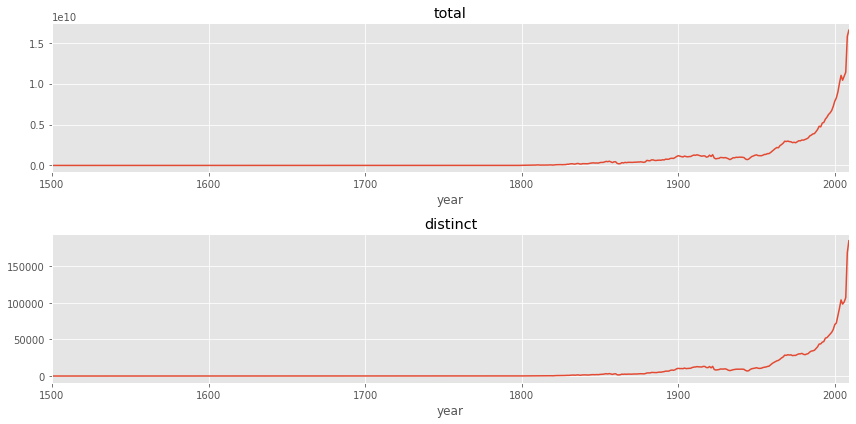

In [5]:
df_baseline = pd.read_csv("/mnt/volume_sfo2_02/googlebooks-eng-us-all-totalcounts-20120701.txt",
                          lineterminator='\t',
                          names=['year', 'total', 'page', 'distinct']).set_index('year')
_, axes = plt.subplots(nrows=2, ncols=1)
df_baseline['total'].plot(ax=axes[0], title='total')
df_baseline['distinct'].plot(ax=axes[1], title='distinct')
plt.tight_layout()


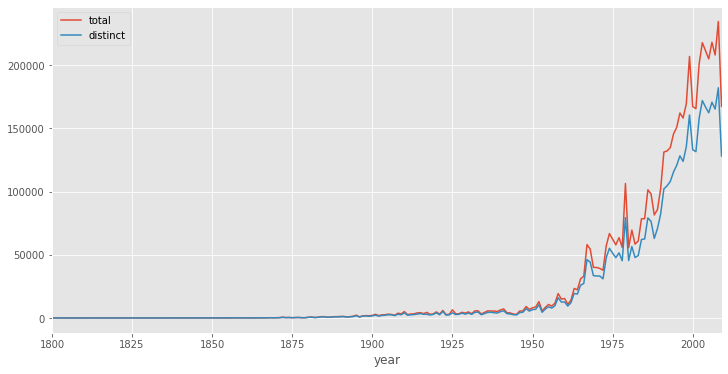

In [6]:
df.groupby(['year'])[['total', 'distinct']].sum().plot();

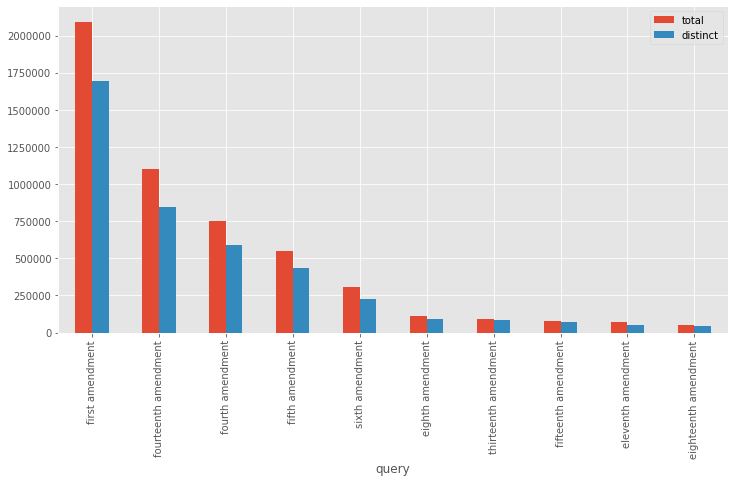

In [7]:
df_queries = (df.groupby(['query'])[['total', 'distinct']]
     .sum()
     .sort_values('total', ascending=False))

(df_queries.nlargest(10, 'total')
     .plot.bar());

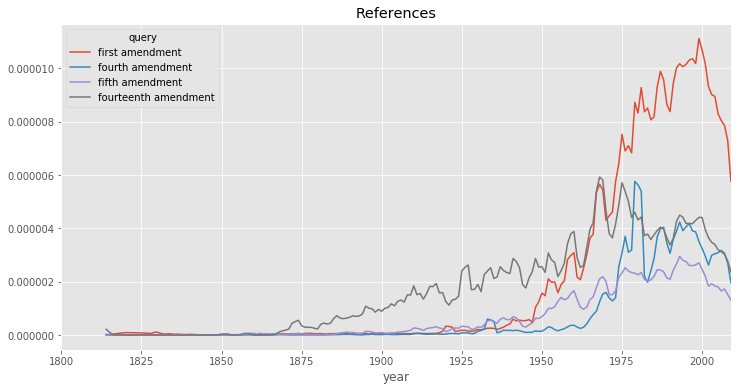

In [8]:
top_n = df_queries.nlargest(4, 'total').index

df_query_year = (
    df.groupby(['query', 'year'])[['total', 'distinct']].sum() /
    (df_baseline)
)

(df_query_year.loc[top_n, :]
     .unstack('query')['total']
     .reindex([q for q in QUERIES if q in top_n], axis=1)
     .fillna(0)
     .sort_index()
     .rolling(3)
     .mean()
     .plot(title="References"))

# Similar to https://books.google.com/ngrams/graph?content=first+amendment%2Cfourteenth+amendment%2Cfourth+amendment%2Cfifth+amendment&case_insensitive=on&year_start=1800&year_end=2008&corpus=17&smoothing=2&share=&direct_url=t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0#t4%3B%2Cfirst%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFirst%20Amendment%3B%2Cc0%3B%3Bfirst%20amendment%3B%2Cc0%3B%3Bfirst%20Amendment%3B%2Cc0%3B.t4%3B%2Cfourteenth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourteenth%20Amendment%3B%2Cc0%3B%3Bfourteenth%20amendment%3B%2Cc0%3B.t4%3B%2Cfourth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFourth%20Amendment%3B%2Cc0%3B%3Bfourth%20amendment%3B%2Cc0%3B%3Bfourth%20Amendment%3B%2Cc0%3B.t4%3B%2Cfifth%20amendment%3B%2Cc0%3B%2Cs0%3B%3BFifth%20Amendment%3B%2Cc0%3B%3Bfifth%20amendment%3B%2Cc0%3B%3Bfifth%20Amendment%3B%2Cc0


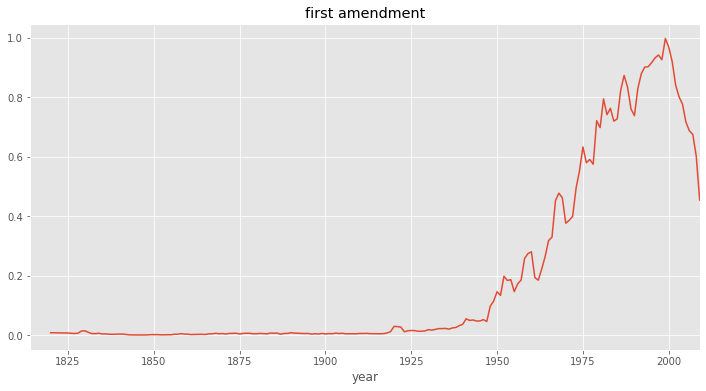

In [9]:
query = AMENDMENTS[1 - 1]

display(df_query_year.loc[query, 'distinct']
     .fillna(0)
     .sort_index()
     .rolling(3)
     .mean()
     .plot(title=query))

In [10]:
df_query = df[(df['query'] == query)]

display(highest_table(df_query, 6, 'decade'))

display(highest_table(df_query, 6, 'decade', df_denominator=df))


,0,1,2,3,4,5
1810,proposed,house,,,,
1820,proposed,senate,prohibits,,,
1830,senate,house,proposed,offered,contained,federal
1840,house,opposed,found,constitution,,
1850,senate,house,proposed,amendment,contrary,constitution
1860,reported,senate,house,proposed,constitution,contained
1870,senate,substituted,house,offered,proposed,amendment
1880,reported,substituted,senate,impose,proposed,house
1890,vote,substituted,reported,senate,proposed,offered
1900,reported,substituted,vote,proposed,senate,disregard


,0,1,2,3,4,5
1810,house,proposed,,,,
1820,senate,proposed,prohibits,,,
1830,senate,house,offered,proposed,contained,constitution
1840,house,opposed,found,constitution,,
1850,senate,house,amendment,proposed,contrary,constitution
1860,reported,senate,house,proposed,contained,constitution
1870,senate,substituted,house,offered,spirit,forbidden
1880,reported,substituted,senate,heard,presupposition,house
1890,substituted,reported,senate,vote,offered,house
1900,reported,substituted,senate,disregard,house,similar


None

None

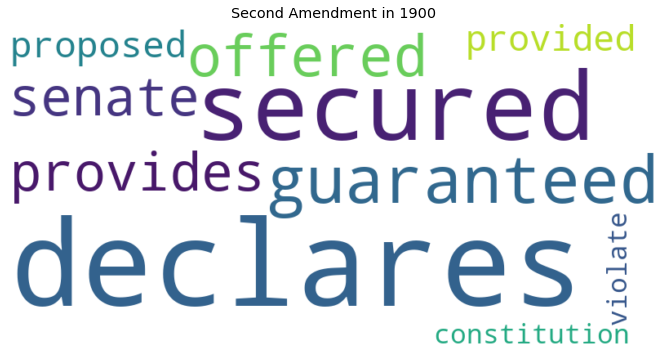

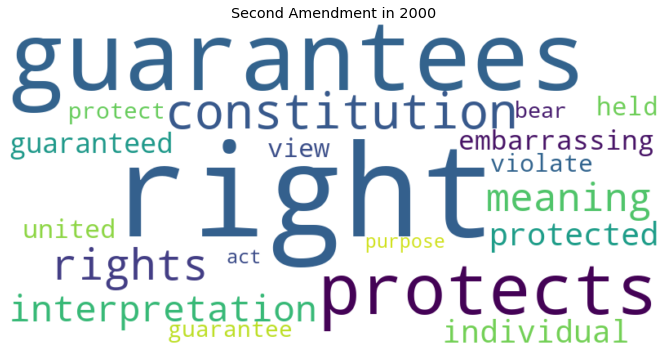

In [11]:
def draw_word_cloud(freq_dict):

    word_cloud = (WordCloud(width=800, height=400, stopwords=STOP_WORDS, max_words=20, background_color='white')
        .fit_words(freq_dict))
    
    plt.figure(figsize=(12, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    
def plot_amendment_decade(amendment, decade):
    df_query = df[(df['query'] == amendment)]
    draw_word_cloud(df_query[df_query['decade'] == decade].set_index("w")['total'].to_dict())
    plt.title("{} in {}".format(amendment.title(), decade))
    
display(plot_amendment_decade(AMENDMENTS[2-1], 1900))
display(plot_amendment_decade(AMENDMENTS[2-1], 2000))